In [248]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [249]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Preparation

In [250]:
# Unify column names
df.columns = df.columns.str.lower().str.replace(" ", "_")
# List of all categorical columns
categorical_columns = list(df.dtypes[df.dtypes == object].index)
# Unify categolrical columns
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

In [251]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [252]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

### Model Setup

In [253]:
# 80% train + val = train_full, 20% test
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
# 75% train, 25% val out of train_full 
# 60% train, 20% val, 20% test out of df
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["converted"]
y_val = df_val["converted"]
y_test = df_test["converted"]

# delete "churn from df_train, df_val, df_test (not from df)
del df_train["converted"]
del df_val["converted"]
del df_test["converted"]

In [254]:
# train a model
def train(df, y_train):
    dicts = df[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver="liblinear")
    model.fit(X_train, y_train)
    
    return dv, model

In [255]:
dv, model = train(df_train, y_train)

In [256]:
# make predictions 
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [257]:
y_pred = predict(df_train,dv,model)

In [258]:
from sklearn.metrics import auc,roc_auc_score

In [259]:
roc_auc_score(y_train, y_pred)

0.8338556431608788

In [260]:
for i in numerical:
    auc = roc_auc_score(y_train, df_train[i])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[i])
    print('%9s, %.3f' % (i, auc))
    

number_of_courses_viewed, 0.764
annual_income, 0.552
interaction_count, 0.738
lead_score, 0.614


**Q1: Which numerical variable (among the following 4) has the highest AUC?**

**A: number_of_courses_viewed**

In [261]:
train_dicts = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_val = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_val, y_val)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [262]:
roc_auc_score(y_val, y_pred)

0.8416259227303232

In [263]:
y_pred_bin = model.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred_bin)
rounded_auc = round(roc_auc, 3)
rounded_auc

0.713

**Q2: What's the AUC of this model on the validation dataset? (round to 3 digits)**

**A: 0.72**

In [264]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [265]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [266]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,117,0,5
30,0.3,171,103,0,19
40,0.4,166,80,5,42
50,0.5,157,60,14,62
60,0.6,133,35,38,87
70,0.7,97,13,74,109
80,0.8,65,7,106,115
90,0.9,36,1,135,121


In [267]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

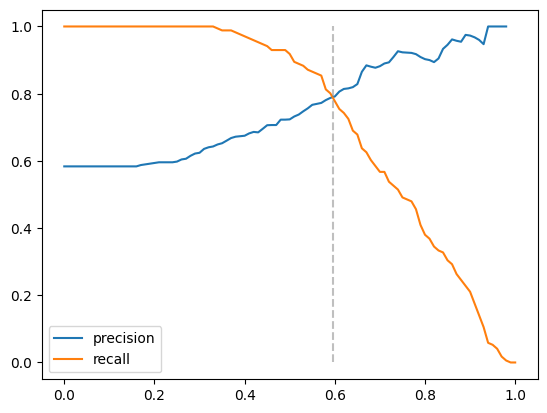

In [268]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.595, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

**Q3: At which threshold precision and recall curves intersect?**

**A: 0.545**

In [269]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

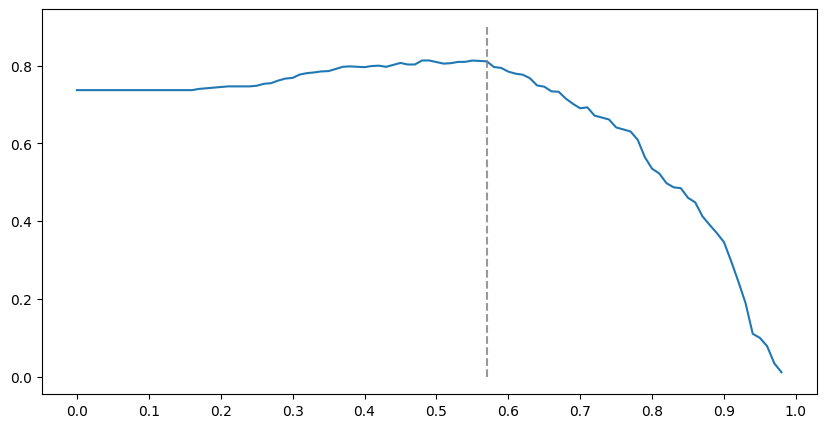

In [270]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.57, 0, 0.9, color='grey', linestyle='--', alpha=0.8)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

**Q4: At which threshold F1 is maximal?**

**A: 0.54**

In [271]:
from sklearn.model_selection import KFold

In [272]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical+numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [273]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


**Q5: How large is standard deviation of the scores across different folds?**

**A: 0.36**

In [274]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%3s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.822 +- 0.036
C=0.001, 0.822 +- 0.036
C=  1, 0.822 +- 0.036


**Q6: Which C leads to the best mean score?**
**A: 0.000001**